In [294]:
%matplotlib inline
%reset
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import scipy

import SchemDraw as schem # to draw schematics (install using 'pip install SchemDraw')
import SchemDraw.elements as e

import skrf as rf # scikit-rf (install using 'conda -c scikit-rf scikit-rf')

import sympy # sympy (install using 'conda -c sympy sympy')
from sympy import I # imaginary symbol

rf.stylely() # enable scikit-rf plot styles
sympy.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)
# Useful links:
# http://www.qsl.net/in3otd/electronics/Z_fitting/impedance_fitting.html

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [295]:
# sympy fun! - just for reference
# x = sympy.symbols('x')
# display(sympy.diff(sympy.sin(x) * sympy.exp(x), x))
# display(sympy.integrate(sympy.sin(x**2), (x, -sympy.oo, sympy.oo)))
# sympy.subs - expr.subs([(sym1, val1), (sym2, val2)]) WARNING: not very performant use lambdify instead with numpy
# sympy.Eq (sets 2 expressions equal symbolically (dont use ==))
# sympy.simplify (to check symbolic equality: simplify(expr1 - expr2))
# sympy.equals (test expression equality with random numerical evaluation) expr1.equals(expr2)
# sympy.Integer(x) - creates SymPy integer
# sympy.Rational(x,y) - creates symbolic fraction
# sympy.evalf - expr.evalf() - evaluates numerical expression into floating point number
# sympy.lambdify((sym1, sym2, sym3), expr, "numpy") - returns a function

In [296]:
# helper functions
def ll(a, b): # return a and b in parallel (symbolically)
    return (a * b) / (a + b)
def mag2db(mag):
    return np.multiply(20.0, np.log10(mag))
def db2mag(db):
    return np.power(10, np.divide(db, 20.0))

In [353]:
def sma_dummy_short_model():
    # Symbolic
    R, L, C, w = sympy.symbols('R L C \omega', real=True)
    L_j = I * w * L
    C_j = (I * w * C)**-1
    Z11 = sympy.simplify(ll(L_j + R, C_j))
    Z11_function = sympy.lambdify((w, C, L, R), Z11, "numpy")
    print("SMA Dummy Short Z11 Symbolic Model:")
    display(Z11)
    
    # Schematic
    print("SMA Dummy Short Schematic Model:")
    d = schem.Drawing(unit=1.5)
    C_sma = d.add(e.CAP, d='up', label='$C_{sma}$')
    d.add(e.RES, d='right', label='$R_{sma}$')
    L_sma = d.add(e.INDUCTOR, d='right', label='$L_{sma}$')
    d.add(e.RES, d='down', botlabel='$R_{short}$')
    L_short = d.add(e.INDUCTOR, d='down', botlabel='$L_{short}$')
    d.add(e.LINE, d='right', l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', xy=L_sma.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='left', xy=C_sma.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, xy=C_sma.start, to=L_short.end)
    d.add(e.LINE, d='left', xy=C_sma.start, l=1)
    d.add(e.DOT_OPEN)
    d.draw()
    return Z11_function

def open_model():
    # Symbolic
    C_fr, C_pp, w = sympy.symbols('C_fr C_pp \omega', real=True)
    C_fr_j = (I * w * C_fr)**-1
    C_pp_j = (I * w * C_pp)**-1
    Z11 = sympy.simplify(ll(C_fr_j, C_pp_j))
    Z11_function = sympy.lambdify((w, C_fr, C_pp), Z11, "numpy")
    print("Open Z11 Symbolic Model:")
    display(Z11)

    # Schematic
    print("Open Schematic Model:")
    d = schem.Drawing(unit=2)
    port1_gnd = d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', l=1)
    C_pp1 = d.add(e.CAP, d='up', label='$C_{pp}$')
    C_fr = d.add(e.CAP, d='right', label='$C_{fr}$')
    C_pp2 = d.add(e.CAP, d='down', botlabel='$C_{pp}$')
    d.add(e.LINE, d='right', l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', xy=C_fr.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, xy=C_pp1.start, tox=C_pp2.end)
    d.add(e.LINE, d='left', xy=C_fr.start, l=1)
    d.add(e.DOT_OPEN)
    d.draw()
    return Z11_function

SMA Dummy Short Z11 Symbolic Model:


     -ⅈ⋅(ⅈ⋅L⋅\omega + R)     
─────────────────────────────
C⋅\omega⋅(ⅈ⋅L⋅\omega + R) - ⅈ

SMA Dummy Short Schematic Model:


<function numpy.<lambda>>

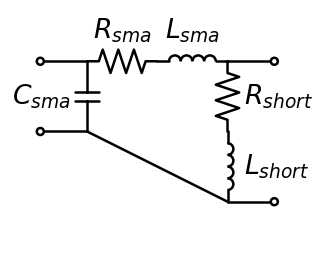

In [354]:
sma_dummy_short_model()

Open Z11 Symbolic Model:


        -ⅈ         
───────────────────
\omega⋅(C_fr + Cₚₚ)

Open Schematic Model:


<function numpy.<lambda>>

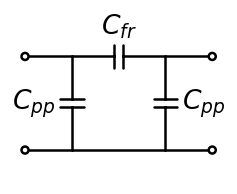

In [355]:
open_model()

L = 2.055766 nH | C = 0.271229 pF | R = 0.183309 Ohms


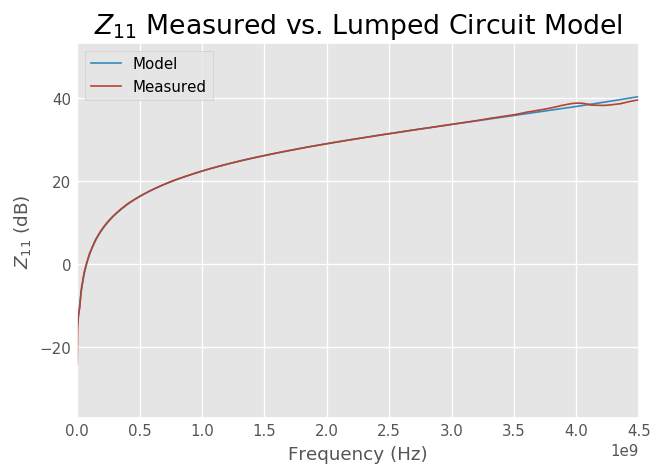

In [123]:
# Characterization of the SMA dummy short (model fitting)
#sma_dummy_short_s_params_measured = rf.Network('data/sma_dummy_short_new_cal.S2P')
sma_dummy_short_s_params_measured = rf.Network('data/sma_dummy_short.S2P')

measured_freqs_omega = sma_dummy_short_s_params_measured.frequency.w 
measured_freqs_f = np.divide(measured_freqs_omega, 2 * np.pi)

measured_S11 =  sma_dummy_short_s_params_measured.s[:,0,0]
measured_Z11 = np.multiply(50, (np.add(1, measured_S11)) / (np.subtract(1, measured_S11)))

def sma_dummy_short_z11_loss_fn(var, plot=False, debug=False):
    if debug:
        print(var)
    C_sma = np.tile(var[0], len(measured_freqs_f))
    L_sma = np.tile(var[1], len(measured_freqs_f))
    R_sma = np.tile(var[2], len(measured_freqs_f))
    Z11_model = sma_dummy_short_Z11_model(measured_freqs_omega, C_sma, L_sma, R_sma)
    if plot:
        plt.figure()
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(Z11_model)))
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(measured_Z11)))
        plt.title('$Z_{11}$ Measured vs. Lumped Circuit Model')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$Z_{11}$ (dB)')
        plt.legend(['Model', 'Measured'])
    #MSE = (1.0 / len(measured_freqs_f)) * np.sum(np.square(np.abs(np.subtract(np.log10(Z11_model), np.log10(measured_Z11)))))
    MSE = (1.0 / len(measured_freqs_f)) \
        * np.sum(np.abs(np.subtract(np.log(np.abs(Z11_model)), np.log(np.abs(measured_Z11)))))
    if debug:
        print(MSE)
    return MSE

model_fit = scipy.optimize.minimize(sma_dummy_short_z11_loss_fn, (1e-12, 1e-9, 100e-3), method='Nelder-Mead', options={'fatol': 0.000001})
sma_dummy_short_z11_loss_fn(model_fit.x, plot=True, debug=False)
print("L = %f nH | C = %f pF | R = %f Ohms" %(model_fit.x[1]/1e-9, model_fit.x[0]/1e-12, model_fit.x[2]))

In [126]:
#sma_dummy_short_s_params_measured.s11.plot_s_db()
#sma_dummy_short_s_params_measured.s11.plot_s_smith()

In [177]:
# Model for 0.7mm tline
R_tline, L_tline, C_tline, G_tline, w = sympy.symbols('R_tline L_tline C_tline G_tline \omega', real=True)

L_tline_j = I * w * L_tline
C_tline_j = (I * w * C_tline)**-1

#seven_mm_tline_Z11 = sympy.simplify(ll(ll(C_tline_j/2.0, G_tline/2.0) + L_tline_j + R_tline, ll(C_tline_j/2.0, G_tline/2.0)))
#seven_mm_tline_Z11 = sympy.simplify(ll(C_tline_j/2.0 + L_tline_j + R_tline, C_tline_j/2.0))
#seven_mm_tline_Z11 = sympy.simplify(ll(L_tline_j + R_tline, C_tline_j))
seven_mm_tline_Z11 = sympy.simplify(ll(L_tline_j, C_tline_j))

display(seven_mm_tline_Z11)
seven_mm_tline_Z11_model = sympy.lambdify((w, C_tline, L_tline), seven_mm_tline_Z11, "numpy")

    -ⅈ⋅Lₜₗᵢₙₑ⋅\omega     
─────────────────────────
                    2    
Cₜₗᵢₙₑ⋅Lₜₗᵢₙₑ⋅\omega  - 1

[  1.00000000e-12   1.00000000e-09]
4.63711107041
[  1.05000000e-12   1.00000000e-09]
4.63279487941
[  1.00000000e-12   1.05000000e-09]
4.56479528606
[  1.05000000e-12   1.05000000e-09]
4.56031787935
[  1.07500000e-12   1.07500000e-09]
4.52336561459
[  1.02500000e-12   1.12500000e-09]
4.46155777837
[  1.01250000e-12   1.18750000e-09]
4.38475515115
[  1.08750000e-12   1.21250000e-09]
4.34747658083
[  1.13125000e-12   1.29375000e-09]
4.25070387594
[  1.06875000e-12   1.40625000e-09]
4.14098397486
[  1.06562500e-12   1.57187500e-09]
3.98967099105
[  1.18437500e-12   1.67812500e-09]
3.88732747162
[  1.27031250e-12   1.92343750e-09]
3.69627394716
[  1.20468750e-12   2.20156250e-09]
3.53444341009
[  1.24140625e-12   2.65546875e-09]
3.3005819853
[  1.44609375e-12   3.00703125e-09]
3.11710509149
[  1.63632812e-12   3.72460937e-09]
2.8660902809
[  1.60742187e-12   4.45664062e-09]
2.6584375118
[  1.77597656e-12   5.72324219e-09]
2.09070408702
[  2.17089844e-12   6.79238281e-09]
1.64491730457
[  

IndexError: index 2 is out of bounds for axis 0 with size 2

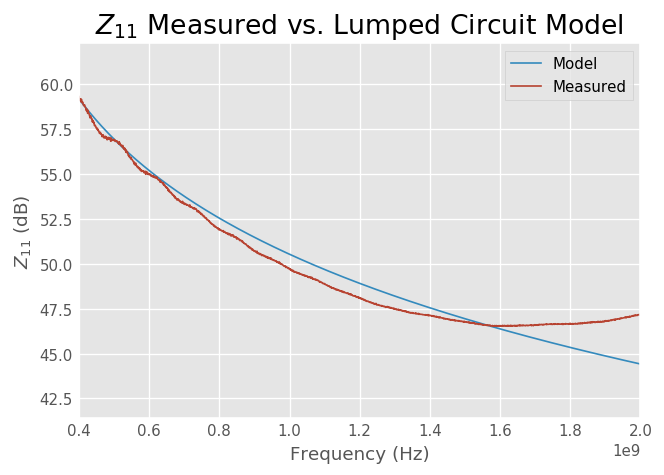

In [178]:
small_tline_data = rf.Network('original_data/thru_0p7mm.s2p')['0.4-2Ghz']

measured_freqs_omega = small_tline_data.frequency.w 
measured_freqs_f = np.divide(measured_freqs_omega, 2 * np.pi)

measured_S11 = small_tline_data.s[:,0,0]
#measured_Z11 = np.multiply(50, (np.add(1, measured_S11)) / (np.subtract(1, measured_S11)))
measured_Z11 = small_tline_data.z[:,0,0]

def tline_z11_loss_fn(var, plot=False, debug=True):
    if debug:
        print(var)
    C_tline = np.tile(var[0], len(measured_freqs_f))
    L_tline = np.tile(var[1], len(measured_freqs_f))
    #R_tline = np.tile(var[2], len(measured_freqs_f))
    #G_tline = np.tile(var[3], len(measured_freqs_f))
    Z11_model = seven_mm_tline_Z11_model(measured_freqs_omega, C_tline, L_tline)
    if plot:
        plt.figure()
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(Z11_model)))
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(measured_Z11)))
        plt.title('$Z_{11}$ Measured vs. Lumped Circuit Model')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$Z_{11}$ (dB)')
        plt.legend(['Model', 'Measured'])
    MSE = (1.0 / len(measured_freqs_f)) * np.sum(np.square(np.abs(np.subtract(np.log10(Z11_model), np.log10(measured_Z11)))))
    #MSE = (1.0 / len(measured_freqs_f)) \
    #    * np.sum(np.abs(np.subtract(np.log(np.abs(Z11_model)), np.log(np.abs(measured_Z11)))))
    if debug:
        print(MSE)
    return MSE

model_fit = scipy.optimize.minimize(tline_z11_loss_fn, (1e-12, 1e-9), method='Nelder-Mead')
tline_z11_loss_fn(model_fit.x, plot=True, debug=False)
print("L = %f nH | C = %f pF | R = %f Ohms" %(model_fit.x[1]/1e-9, model_fit.x[0]/1e-12, model_fit.x[2]))
#small_tline_data.plot_s_deg()

        -ⅈ         
───────────────────
\omega⋅(C_fr + Cₚₚ)

[  1.00000000e-14   1.00000000e-11]
4.56943528091
[  1.05000000e-14   1.00000000e-11]
4.56948522971
[  1.00000000e-14   1.05000000e-11]
4.61817787247
[  1.05000000e-14   9.50000000e-12]
4.51824713899
[  1.07500000e-14   9.00000000e-12]
4.46426899658
[  1.02500000e-14   9.00000000e-12]
4.46421350576
[  1.01250000e-14   8.50000000e-12]
4.40710731866
[  1.08750000e-14   7.50000000e-12]
4.28220265789
[  1.13125000e-14   6.25000000e-12]
4.10024051525
[  1.06875000e-14   5.75000000e-12]
4.01690751281
[  1.06562500e-14   4.12500000e-12]
3.68549670963
[  1.18437500e-14   1.87500000e-12]
2.90075614715
[  1.27031250e-14  -1.43750000e-12]
2.61987994728
[  1.20468750e-14  -3.56250000e-12]
3.53292592377
[  1.40937500e-14  -9.12500000e-12]
4.4753228725
[  1.15156250e-14   8.12500000e-13]
2.07228490071
[  1.21718750e-14   2.93750000e-12]
3.34754462293
[  1.21406250e-14   1.31250000e-12]
2.54699188382
[  1.09531250e-14   3.56250000e-12]
3.53938307778
[  1.22656250e-14  -1.87500000e-13]
0.531588538996


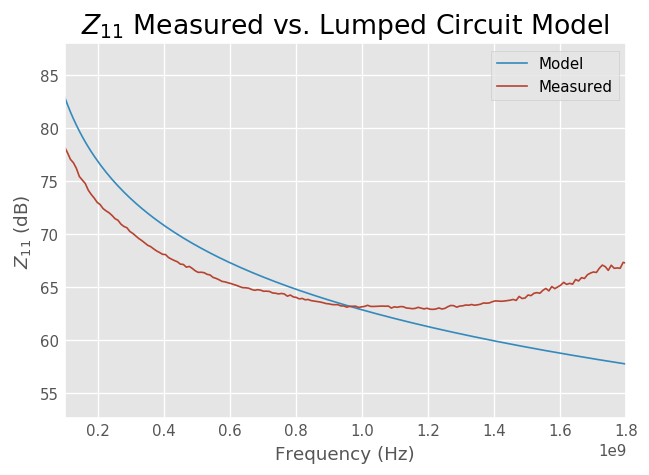

In [279]:
# Model for shunt-short board (via inductance)
open_data = rf.Network('original_data/OPEN.S2P')['0.1-1.8Ghz']

measured_freqs_omega = open_data.frequency.w 
measured_freqs_f = np.divide(measured_freqs_omega, 2 * np.pi)

measured_S11 = open_data.s[:,0,0]
measured_Z11 = open_data.z[:,0,0]

def open_z11_loss_fn(var, plot=False, debug=True):
    if debug:
        print(var)
    C_fr = np.tile(var[0], len(measured_freqs_f))
    C_pp = np.tile(var[1], len(measured_freqs_f))
    #C_feed = np.tile(var[2], len(measured_freqs_f))
    #L_open = np.tile(var[2], len(measured_freqs_f))

    Z11_model = open_Z11_model(measured_freqs_omega, C_fr, C_pp)
    if plot:
        plt.figure()
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(Z11_model)))
        plt.plot(measured_freqs_f, 20*np.log10(np.abs(measured_Z11)))
        #plt.plot(measured_freqs_f, np.angle(Z11_model, deg=True))
        #plt.plot(measured_freqs_f, np.angle(measured_Z11, deg=True))

        plt.title('$Z_{11}$ Measured vs. Lumped Circuit Model')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$Z_{11}$ (dB)')
        plt.legend(['Model', 'Measured'])
    #MSE = (1.0 / len(measured_freqs_f)) * np.sum(np.square(np.abs(np.subtract(np.log10(Z11_model), np.log10(measured_Z11)))))
    MSE = (1.0 / len(measured_freqs_f)) \
        * np.sum(np.abs(np.subtract(np.log(np.abs(Z11_model)), np.log(np.abs(measured_Z11)))))
    #MSE = (1.0 / len(measured_freqs_f)) \
    #    * np.sum(np.square(np.subtract(Z11_model, measured_Z11)))

    if debug:
        print(MSE)
    return np.abs(MSE)

model_fit = scipy.optimize.minimize(open_z11_loss_fn, (10e-15, 10e-12), method='Nelder-Mead')
open_z11_loss_fn(model_fit.x, plot=True, debug=False)
print("C_fr = %f fF | C_pp = %f pF" %(model_fit.x[0]/1e-15, model_fit.x[1]/1e-12))
#small_tline_data.plot_s_deg()
#open_z11_loss_fn((10e-15, 0.09e-12, 1e-30, 1e-12), plot=True, debug=False)